# Psi method simulation 

## Overview of the method

The Psi method is a Bayesian adaptive alogrithm to estimate the threshold and slope of a psychometric function. Most of the concepts in this notebook is taken from Kontesevich and Tyler 1997 from the Journal Vision Research. 

The threshold of the psychometric function, denoted by $\alpha$, is the inflection point of the function, or the point at wich the response is 50/50 (in this specific case). It represents the bias in the estimates. The slope, denoted by $\beta$, reflects the uncertainty in the estimate. 

This specific notebook and simulations were designed with a specific task in mind: A 2-Alaternate forced choice (AFC) task with the goal of estimating the sense of lower limb symmetry. Individuals stand on a split-belt treadmill with visual and auditory feedback occluded. The belt slowly moves their test limb from a randomly chosen distractor location to the stimulus location. Participants are then asked to respond if their left or right limb is more anterior. Thus, the threshold is the estimate of the individuals sense of limb symmetry. The algorithm in this notebook is written in reference to this task where the left limb is the test stimulus and is being passively moved by the treadmill and right limb is stationary.

For detailed explination, see the Explainer notebook. Here we have simulations that answer various questions about the method. 



***
***

## Import libraries 

In [4]:
#Import python libs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import expon
from scipy.stats import norm
from numpy.random import random
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18})

## Define functions

The main functions are the lookup table, the entropy function and we put them all together in the psi simulation function

### Look up table

In [5]:
#Look up table
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[a_i,b_i,x_i] = psi
                p_right_look[a_i,b_i,x_i] = 1-psi

    return p_left_look, p_right_look

### Entropy calculation

In [6]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = np.multiply(Prior,p_left_look[:,:,i])
        Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_right = np.multiply(Prior,p_right_look[:,:,i])
        Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    return EH, best_X

### Unique Values function

In [30]:
def UniqueVals(stims, responses):
    
    """
    This function takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    """
    
    Unique_stims, stim_idx = np.unique(stims, return_index=True)
    Unique_stims = stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in Unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return Unique_stims, Nstims, Kleft


### Correspondance correlation coefficient

In [38]:
def calc_CCC(sim,est):
    """
    This function calculate the correspondance correlation coefficient
    """
    #Claculate rho
    r, _ = stats.pearsonr(sim,est)

    #Calculate CCC
    CCC = (2*r*np.std(sim)*np.std(est)) / ((np.mean(sim) - np.mean(est))**2 + (np.var(sim) + np.var(est)))

    return CCC

### Experiment simulation

In [ ]:
#PSI simulation 
def PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    
    #Start the experiment
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)

        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

## Single participant simulation

**Prior justification:** We need to create a 2d prior made up of $\alpha$ and $\beta$ probabilities

**Alpha:** The maximum entropy distirbution for alpha is a Gaussian. We should center this on 0 because we have no reason to think there would be a bias prior to testing. The standard deviation should also reflect our possible range of alpha values (-100 to 100). Therefore, we should set it at 40, that way 95% of the distribution lies within -80 and 80. Values outside of that should be very unlikely. 

**Beta:** The maximum entropy distribution for beta is an exponential distribution. We can parameterize this distribution with $\lambda$ which is the decay parameter or event rate. In the python function `expon.pdf` there are two parameters, loc and scale. The loc parameter should be 0 because we do not want to shift the probability distribuiton. The scale parameter is equivilant to $\frac{\displaystyle 1}{\displaystyle \lambda}$ where $\lambda$ is the decay parameter. The full equation is $y = \frac{\displaystyle 1}{\displaystyle \lambda} * \exp^{\frac{\displaystyle -x}{\displaystyle \lambda}}$. In this case, $\lambda$ can be interpreted as the $\beta$ parameter that has ~36% probability relative to the other potential $\beta$ values. That means the value we choose for $\lambda$ should be one which we think is towards the edge of being unlikely to show up in our sample. Based on our pilot data, 20 is a good value for this. 

### Create look up tables and priors

Sum of prior =  1


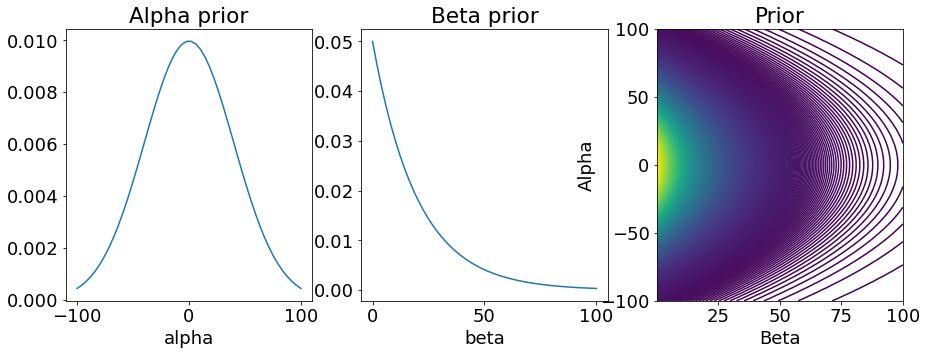

In [5]:
#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0,40)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))

#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

print('Sum of prior = ', round(sum(sum(Prior))))

#Plot
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=False)
ax[0].plot(a_range,p_alpha)
ax[0].set(title='Alpha prior',xlabel='alpha')
ax[1].plot(b_range,p_beta)
ax[1].set(title='Beta prior',xlabel='beta')
ax[2].contour(b_range,a_range,Prior,1000)
ax[2].set(title='Prior',xlabel='Beta',ylabel='Alpha')
plt.show()

### Simulate the experiment

In [6]:
#Set some values for the expeirment
Ntrials = 50
#Set the parameters
alpha_sim = norm.rvs(0,20)
beta_sim = expon.rvs(0,20)
params = [alpha_sim,
          beta_sim, 
          0.02, 
          0.02]

#Stimulate
alpha_EV, beta_EV, stims, responses, Posterior = PSIsim(
    Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

print('Alpha:')
print('Simulated = ' + str(round(alpha_sim,2)))
print('Estimated = ' + str(round(alpha_EV[-1],2)))
print('')
print('Beta:')
print('Simulated = ' + str(round(beta_sim,2)))
print('Estimated = ' + str(round(beta_EV[-1],2)))

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha:
Simulated = -28.82
Estimated = -34.69

Beta:
Simulated = 20.1
Estimated = 24.85


### Plot the stimulation

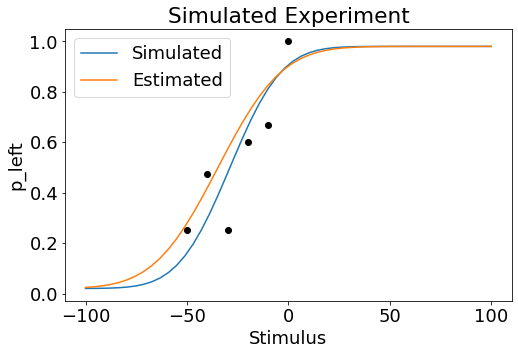

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/501549978.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ko-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[0].plot(np.argwhere(responses==1),stims[responses==1],'ko-',label='r = left',fillstyle='none',linestyle='none')
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/501549978.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ko-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[0].plot(np.argwhere(responses==0),stims[responses==0],'ko-',label='r = right',linestyle='none')


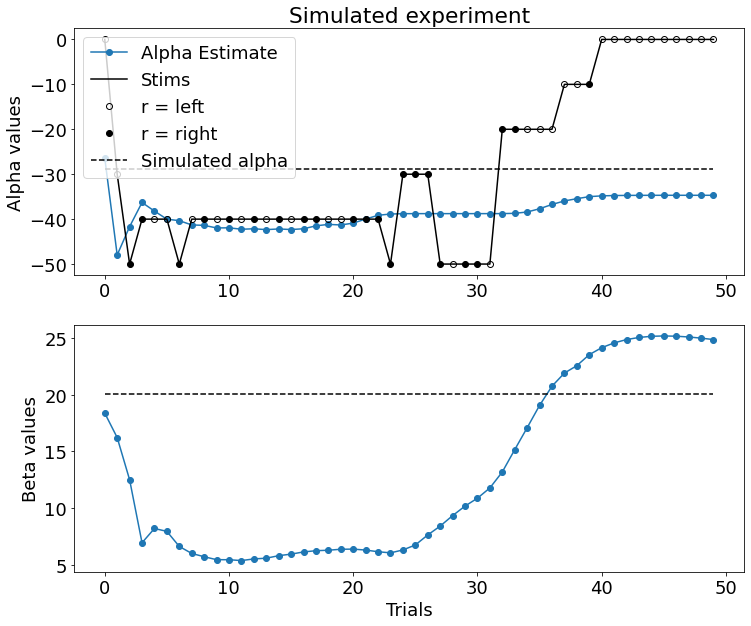

In [8]:
#Set up the plot 
psi_sim = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_sim,beta_sim)
psi_est = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_EV[-1],beta_EV[-1])

#Account for repeated stimuli 
Unique_stims, stim_idx = np.unique(stims, return_index=True)
Unique_stims = stims[np.sort(stim_idx)]
Nstims = []
Kleft = []
for u in Unique_stims:
    stim_idx = np.argwhere(u==stims)[:,0]
    Nstims = np.append(Nstims,len(stim_idx))
    Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

#Plot the psychometric function
fig, ax = plt.subplots(1,figsize=(8,5))
ax.plot(a_range,psi_sim,label='Simulated')
ax.plot(a_range,psi_est,label='Estimated')
ax.plot(Unique_stims,(Kleft/Nstims),'ko')
ax.set(xlabel='Stimulus',ylabel='p_left',title='Simulated Experiment')
ax.legend()
plt.show()

#Plot the experiment trial by trial
fig, ax = plt.subplots(2,1,figsize=(12,10),tight_layout=False)
ax[0].plot(alpha_EV,'o-',label='Alpha Estimate')
ax[0].plot(stims,'k-',label='Stims')
ax[0].plot(np.argwhere(responses==1),stims[responses==1],'ko-',label='r = left',fillstyle='none',linestyle='none')
ax[0].plot(np.argwhere(responses==0),stims[responses==0],'ko-',label='r = right',linestyle='none')
ax[0].plot(np.ones(len(alpha_EV))*alpha_sim,'k--',label='Simulated alpha')
ax[0].legend()
ax[0].set(title='Simulated experiment',ylabel='Alpha values')
ax[1].plot(beta_EV,'o-',label='Beta Estimate')
ax[1].plot(np.ones(len(beta_EV))*beta_sim,'k--',label='Simulated beta')
ax[1].set(ylabel='Beta values',xlabel='Trials')
plt.show()

## Other Simulations

### Number of trials

How does the number of trials impact the estimates? Greater number of trials should help the estimates of $\alpha$ and $\beta$. This is a trade off, we want the test to be efficient but also reliable and able to recover the parameters consistently. The next block of code simulates to determine which number of trials (within reason) become most reliable. (Warning: This takes a long time to run!!).

Testing 10 trials
Alpha CCC =  0.88
Beta CCC =  0.12


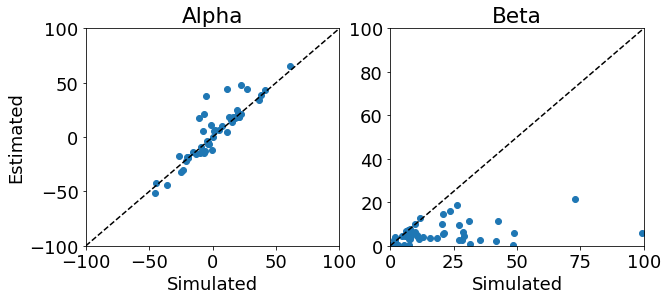

Testing 25 trials


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha CCC =  0.85
Beta CCC =  0.29


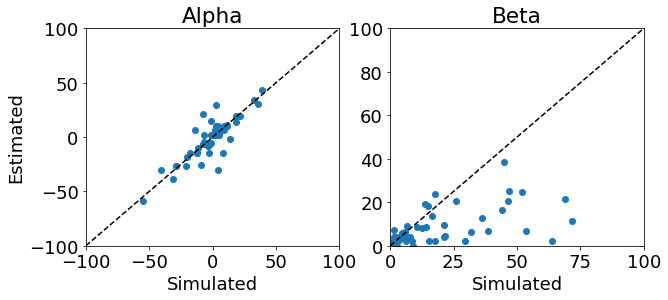

Testing 50 trials


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha CCC =  0.88
Beta CCC =  0.78


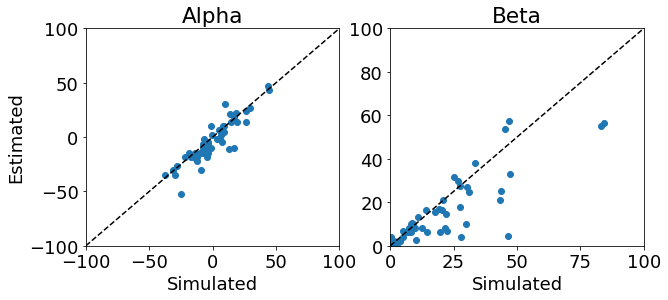

Testing 75 trials


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha CCC =  0.97
Beta CCC =  0.9


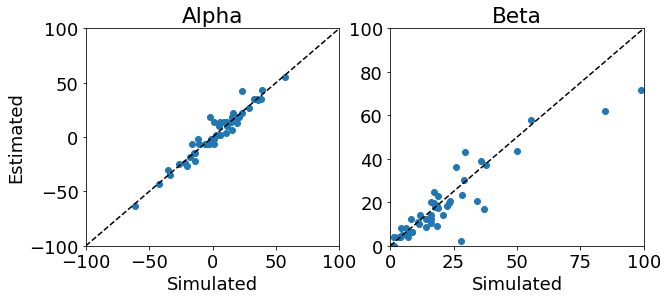

Testing 100 trials


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha CCC =  0.97
Beta CCC =  0.96


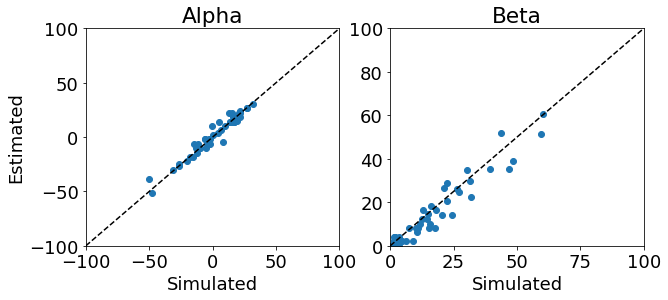

Testing 150 trials


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha CCC =  0.95
Beta CCC =  0.78


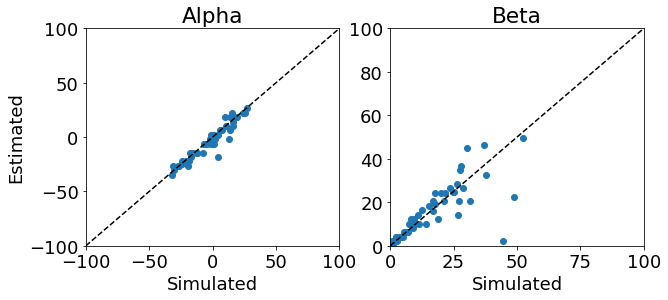

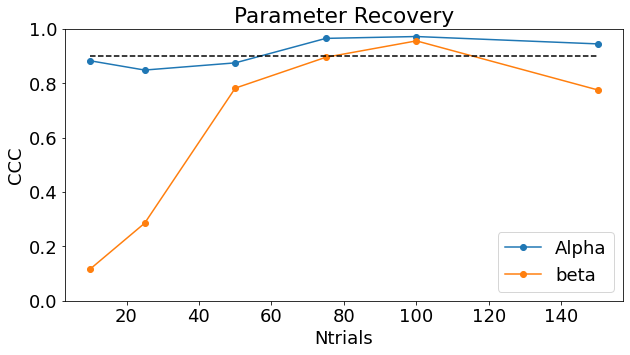

In [9]:
#Set some values for the expeirment
Ntrials = [10, 25, 50, 75, 100, 150]
Nsubjs = 50

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

CCC_alpha = []
CCC_beta = []
for i, n in enumerate(Ntrials):
    print('Testing', n, 'trials')
    Sim_alphas = []
    Sim_betas = []
    Est_alphas = []
    Est_betas = []
    for s in range(Nsubjs):
        
        #Set the priors
        p_alpha = norm.pdf(a_range,0,40)
        p_beta = expon.pdf(b_range,0,20)
        p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
        p_beta = np.reshape(p_beta,(len(p_beta),1))
        Prior = p_alpha @ p_beta.T
        Prior = Prior/np.nansum(np.nansum(Prior))

        #Set the parameters
        alpha_sim = norm.rvs(0,20)
        beta_sim = expon.rvs(0,20)
        params = [alpha_sim, beta_sim, 0.02, 0.02]
        
        Sim_alphas = np.append(Sim_alphas, alpha_sim)
        Sim_betas = np.append(Sim_betas, beta_sim)
    
        #Stimulate
        alpha_EV, beta_EV, _, _, _ = PSIsim(n, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
        
        Est_alphas = np.append(Est_alphas, alpha_EV[-1])
        Est_betas = np.append(Est_betas, beta_EV[-1])

    #Calculate ccc
    r_alpha, _ = stats.pearsonr(Sim_alphas,Est_alphas)
    r_beta, _ = stats.pearsonr(Sim_betas,Est_betas)
    CCC_alpha = np.append(CCC_alpha, 
                          (2*r_alpha*np.std(Sim_alphas)*np.std(Est_alphas)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas))**2 + (np.var(Sim_alphas) + np.var(Est_alphas))))
    CCC_beta = np.append(CCC_beta,
                         (2*r_beta*np.std(Sim_betas)*np.std(Est_betas)) / ((np.mean(Sim_betas) - np.mean(Est_betas))**2 + (np.var(Sim_betas) + np.var(Est_betas))))
    
    print('Alpha CCC = ', str(round(CCC_alpha[i],2)))
    print('Beta CCC = ', str(round(CCC_beta[i],2)))

    #Plot
    fig, ax = plt.subplots(1,2,figsize=(10,4), tight_layout=False)
    ax[0].plot(Sim_alphas,Est_alphas,'o')
    ax[0].plot(a_range,a_range,'k--')
    ax[0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha')
    ax[1].plot(Sim_betas,Est_betas,'o')
    ax[1].plot(b_range,b_range,'k--')
    ax[1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta')
    plt.show()
    
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(Ntrials,CCC_alpha,'o-',label='Alpha')
ax.plot(Ntrials,CCC_beta,'o-',label='beta')
ax.plot(Ntrials,np.ones(len(Ntrials))*0.9,'k--')
ax.set(ylim=(0,1),ylabel='CCC',xlabel='Ntrials',title='Parameter Recovery')
plt.legend()
plt.show()    

Here we measure the argeement between simulated and estimated values using Lins Concordance correlation coefficient (bound between 0 and 1). Briefly, the CCC is a measure of the distance from the unity line - 0.9 represents excellent agreement (dotted line). We see here that even at 10 trials the estimates of alpha are close to excellent. But we need more trials to get to the same level for the esimates of beta. The estimates are really good by 75 trials. There is some drop off at 150 which is surprising. In general, higher beta values are harder to estimate, it looks like there were some high ones in the 150 trial block that were fit poorly.

### Continuous or discrete

Do continuous or discrete stimulus values work better for estimates? Concievibly, we could stimulate at every millimeter. But are millimeters too close together for any human to detect differences between foot position? Differences might not come out in the simulations, but we can test to be sure. 

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11848/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


Alpha Discrete CCC =  0.8
Alpha Continuous CCC =  0.83
Beta Discrete CCC =  0.71
Beta Continuous CCC =  0.52


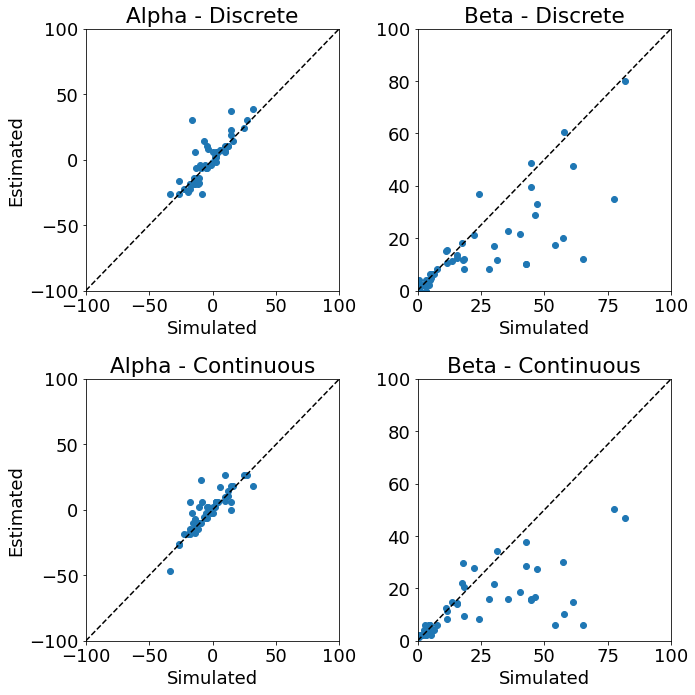

In [10]:
#Set some values for the expeirment
Ntrials = 50
Nsubjs = 50

a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)

#Create the lookup tables
X_dis = np.arange(-100,110,10)
X_con = np.arange(-100,101,1)
p_left_look_Dis, p_right_look_Dis = Psi_lookT(X_dis,a_range,b_range)
p_left_look_Con, p_right_look_Con = Psi_lookT(X_con,a_range,b_range)

Sim_alphas = []
Sim_betas = []
Est_alphas_Dis = []
Est_alphas_Con = []
Est_betas_Dis = []
Est_betas_Con = []
for s in range(Nsubjs):

    #Set the priors
    p_alpha = norm.pdf(a_range,0,40)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
    p_beta = np.reshape(p_beta,(len(p_beta),1))
    Prior = p_alpha @ p_beta.T
    Prior = Prior/np.nansum(np.nansum(Prior))

    #Set the parameters
    alpha_sim = norm.rvs(0,20)
    beta_sim = expon.rvs(0,20)
    params = [alpha_sim, beta_sim, 0.02, 0.02]
    Sim_alphas = np.append(Sim_alphas, alpha_sim)
    Sim_betas = np.append(Sim_betas, beta_sim)

    #Stimulate
    alpha_EV_Dis, beta_EV_Dis, _, _, _ = PSIsim(Ntrials, params, X_dis, a_range, b_range, Prior, p_left_look_Dis, p_right_look_Dis)
    alpha_EV_Con, beta_EV_Con, _, _, _ = PSIsim(Ntrials, params, X_con, a_range, b_range, Prior, p_left_look_Con, p_right_look_Con)

    #Save the estimated parameters
    Est_alphas_Dis = np.append(Est_alphas_Dis, alpha_EV_Dis[-1])
    Est_alphas_Con = np.append(Est_alphas_Con, alpha_EV_Con[-1])
    Est_betas_Dis = np.append(Est_betas_Dis, beta_EV_Dis[-1])
    Est_betas_Con = np.append(Est_betas_Con, beta_EV_Con[-1])

#Calculate ccc
r_alpha_Dis, _ = stats.pearsonr(Sim_alphas,Est_alphas_Dis)
r_alpha_Con, _ = stats.pearsonr(Sim_alphas,Est_alphas_Con)
r_beta_Dis, _ = stats.pearsonr(Sim_betas,Est_betas_Dis)
r_beta_Con, _ = stats.pearsonr(Sim_betas,Est_betas_Con)

CCC_alpha_Dis = (2*r_alpha_Dis*np.std(Sim_alphas)*np.std(Est_alphas_Dis)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas_Dis))**2 + (np.var(Sim_alphas) + np.var(Est_alphas_Dis)))
CCC_alpha_Con = (2*r_alpha_Con*np.std(Sim_alphas)*np.std(Est_alphas_Con)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas_Con))**2 + (np.var(Sim_alphas) + np.var(Est_alphas_Con)))
CCC_beta_Dis = (2*r_beta_Dis*np.std(Sim_betas)*np.std(Est_betas_Dis)) / ((np.mean(Sim_betas) - np.mean(Est_betas_Dis))**2 + (np.var(Sim_betas) + np.var(Est_betas_Dis)))
CCC_beta_Con = (2*r_beta_Con*np.std(Sim_betas)*np.std(Est_betas_Con)) / ((np.mean(Sim_betas) - np.mean(Est_betas_Con))**2 + (np.var(Sim_betas) + np.var(Est_betas_Con)))

print('Alpha Discrete CCC = ', str(round(CCC_alpha_Dis,2)))
print('Alpha Continuous CCC = ', str(round(CCC_alpha_Con,2)))
print('Beta Discrete CCC = ', str(round(CCC_beta_Dis,2)))
print('Beta Continuous CCC = ', str(round(CCC_beta_Con,2)))

#Plot
fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
ax[0,0].plot(Sim_alphas,Est_alphas_Dis,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha - Discrete')

ax[0,1].plot(Sim_betas,Est_betas_Dis,'o')
ax[0,1].plot(b_range,b_range,'k--')
ax[0,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta - Discrete')

ax[1,0].plot(Sim_alphas,Est_alphas_Con,'o')
ax[1,0].plot(a_range,a_range,'k--')
ax[1,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha - Continuous')

ax[1,1].plot(Sim_betas,Est_betas_Con,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta - Continuous')
plt.show()

It looks like the estimates are similar for the alpha values but it seems like discrete stimuli do better for the estimates of beta

### Extreme stimuli 

Does a random extreme stimulus help the estimates? Placing stimuli at the extremes of stimulus ranges can help participants feel more engaged in the task as these trials would provide some reprieve from stimuli very close to their threshold. These extreme stimulus placements can also be used to find estimates for the lapse rate, but we will not be using it for this purpose. In the next code block. I want to compare between random stimli placed at extreme values and stimuli placed just at the most efficient value calculated by the entropy and see which one is better.

1. But how to choose the extreme stimuli? First, I tried selecting just a few extreme trials [-100, -90, -80, 80, 90, 100] and randomly selecting these extreme values (alternating between the high and the low extremes). 
2. Another way to select extreme values, is using the current estimate of the psychometric function. Here we essentially index the probability value of the psychometric function >0.99 or <0.01. Then we select a random stimulus value from those possibilities. 


#### Define additional functions

In [16]:
#First create a new function for the random stimuli
#PSI simulation 
def PSIsim_Rand(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    
    extreme_stims = np.array([-100, -90, -80, 80, 90, 100])
    randbool = 1
    
    #Start the experiment
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        if np.remainder(t+1,15)==0:

            if randbool == 0:
                stim_options = extreme_stims[extreme_stims<0]
                randbool = 1
            elif randbool == 1:
                stim_options = extreme_stims[extreme_stims>0]
                randbool = 0               
            
            stims = np.append(stims, np.random.choice(stim_options))

        else:
            _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
            stims = np.append(stims, best_X)
        
        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

In [17]:
#First create a new function for the random stimuli
#PSI simulation 
def PSIsim_Rand2(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    
    randbool = 1
    
    #Start the experiment
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        if np.remainder(t+1,10)==0:
            current_pdf = norm.cdf(X,alpha_EV[-1],beta_EV[-1])
            
            if randbool == 0:
                stim_options = np.argwhere(current_pdf>0.99)
                randbool = 1
            elif randbool == 1:
                stim_options = np.argwhere(current_pdf<0.01)
                randbool = 0     
            if len(X[stim_options[:,0]]) == 0:
                stims = np.append(stims, np.random.choice([-100,100]))
            else:
                stims = np.append(stims, np.random.choice(X[stim_options[:,0]]))

        else:
            _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
            stims = np.append(stims, best_X)
        
        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

#### Single participant stimulation 

Comparison between two methods of randomization with the standard psi method

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


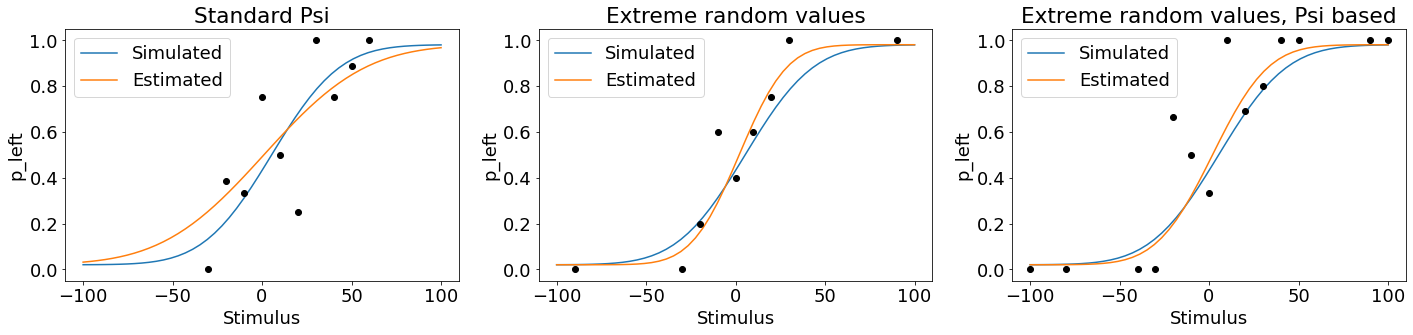

Simulated:
Alpha = 5.37 ; beta = 29.97

Standard Psi estimate:
Alpha = 1.06 ; beta =  44.74

Extreme random values estimate:
Alpha = 2.02 ; beta =  20.98

Extreme random values - psi based estimate:
Alpha = 1.93 ; beta = 24.48


In [48]:
#Set some values for the expeirment
Ntrials = 50

#Set the parameters
alpha_sim = norm.rvs(0,20)
beta_sim = expon.rvs(0,20)
# alpha_sim = 0
# beta_sim = 10
params = [alpha_sim,
          beta_sim, 
          0.02, 
          0.02]

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the Prior
p_alpha = norm.pdf(a_range,0,40)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

alpha_EV, beta_EV, stims, responses, _ = PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
alpha_EV1, beta_EV1, stims1, responses1, _ = PSIsim_Rand(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
alpha_EV2, beta_EV2, stims2, responses2, _ = PSIsim_Rand2(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

#Set up the plot 
psi_sim = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_sim,beta_sim)
psi_est = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_EV[-1],beta_EV[-1])
psi_est1 = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_EV1[-1],beta_EV1[-1])
psi_est2 = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_EV2[-1],beta_EV2[-1])

#Account for repeated stimuli 
Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)
Unique_stims1, Nstims1, Kleft1 = UniqueVals(stims1, responses1)
Unique_stims2, Nstims2, Kleft2 = UniqueVals(stims2, responses2)

#Plot the psychometric function
fig, ax = plt.subplots(1,3,figsize=(20,5),tight_layout=True)
ax[0].plot(a_range,psi_sim,label='Simulated')
ax[0].plot(a_range,psi_est,label='Estimated')
ax[0].plot(Unique_stims,(Kleft/Nstims),'ko')
ax[0].set(xlabel='Stimulus',ylabel='p_left',title='Standard Psi')
ax[0].legend()

ax[1].plot(a_range,psi_sim,label='Simulated')
ax[1].plot(a_range,psi_est1,label='Estimated')
ax[1].plot(Unique_stims1,(Kleft1/Nstims1),'ko')
ax[1].set(xlabel='Stimulus',ylabel='p_left',title='Extreme random values')
ax[1].legend()

ax[2].plot(a_range,psi_sim,label='Simulated')
ax[2].plot(a_range,psi_est2,label='Estimated')
ax[2].plot(Unique_stims2,(Kleft2/Nstims2),'ko')
ax[2].set(xlabel='Stimulus',ylabel='p_left',title='Extreme random values, Psi based')
ax[2].legend()
plt.show()

print('Simulated:')
print('Alpha = ' + str(round(alpha_sim,2)) + ' ; beta = ' + str(round(beta_sim,2)))
print('')
print('Standard Psi estimate:')
print('Alpha = ' + str(round(alpha_EV[-1],2)) + ' ; beta =  ' + str(round(beta_EV[-1],2)))
print('')
print('Extreme random values estimate:')
print('Alpha = ' + str(round(alpha_EV1[-1],2)) + ' ; beta =  ' + str(round(beta_EV1[-1],2)))
print('')
print('Extreme random values - psi based estimate:')
print('Alpha = ' + str(round(alpha_EV2[-1],2)) + ' ; beta = ' + str(round(beta_EV2[-1],2)))

Overall, it looks like the extreme random values work the best. Lets take a look at a greater number of trials and see if this pattern continues

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_9392/1202952732.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


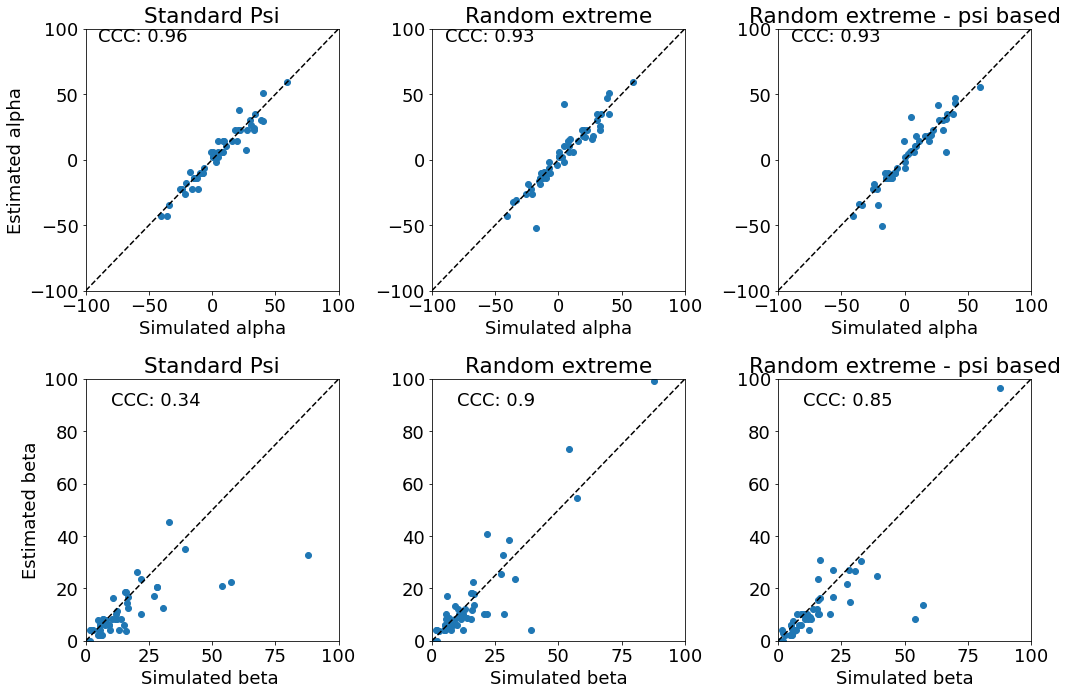

In [49]:
#Set some values for the expeirment
Ntrials = 50
Nsubjs = 50

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

Sim_alphas,Sim_betas,Est_alphas_standard,Est_betas_standard,Est_alphas_rand,Est_betas_rand,Est_alphas_randPsi,Est_betas_randPsi = [], [], [], [], [], [], [], []
for s in range(Nsubjs):

    #Set the priors
    p_alpha = norm.pdf(a_range,0,40)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
    p_beta = np.reshape(p_beta,(len(p_beta),1))
    Prior = p_alpha @ p_beta.T
    Prior = Prior/np.nansum(np.nansum(Prior))

    #Set the parameters
    alpha_sim = norm.rvs(0,20)
    beta_sim = expon.rvs(0,20)
    params = [alpha_sim, beta_sim, 0.02, 0.02]
    Sim_alphas = np.append(Sim_alphas, alpha_sim)
    Sim_betas = np.append(Sim_betas, beta_sim)

    #Stimulate
    alpha_EV_standard, beta_EV_standard, _, _, _ = PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
    alpha_EV_rand, beta_EV_rand, _, _, _ = PSIsim_Rand(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
    alpha_EV_randPsi, beta_EV_randPsi, _, _, _ = PSIsim_Rand2(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

    #Save the estimated parameters
    Est_alphas_standard = np.append(Est_alphas_standard, alpha_EV_standard[-1])
    Est_alphas_rand = np.append(Est_alphas_rand, alpha_EV_rand[-1])
    Est_alphas_randPsi = np.append(Est_alphas_randPsi, alpha_EV_randPsi[-1])

    Est_betas_standard = np.append(Est_betas_standard, beta_EV_standard[-1])
    Est_betas_rand = np.append(Est_betas_rand, beta_EV_rand[-1])
    Est_betas_randPsi = np.append(Est_betas_randPsi, beta_EV_randPsi[-1])

#Calculate CCC
CCC_alpha_standard = calc_CCC(Sim_alphas,Est_alphas_standard)
CCC_alpha_rand = calc_CCC(Sim_alphas,Est_alphas_rand)
CCC_alpha_randPsi = calc_CCC(Sim_alphas,Est_alphas_randPsi)

CCC_beta_standard = calc_CCC(Sim_betas,Est_betas_standard)
CCC_beta_rand = calc_CCC(Sim_betas,Est_betas_rand)
CCC_beta_randPsi = calc_CCC(Sim_betas,Est_betas_randPsi)

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10), tight_layout=True)
ax[0,0].plot(Sim_alphas,Est_alphas_standard,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].text(-90, 90, 'CCC: ' + str(round(CCC_alpha_standard,2)))
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated alpha',ylabel='Estimated alpha',title='Standard Psi')

ax[1,0].plot(Sim_betas,Est_betas_standard,'o')
ax[1,0].plot(b_range,b_range,'k--')
ax[1,0].text(10, 90, 'CCC: ' + str(round(CCC_beta_standard,2)))
ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated beta ',ylabel='Estimated beta', title='Standard Psi')

ax[0,1].plot(Sim_alphas,Est_alphas_rand,'o')
ax[0,1].plot(a_range,a_range,'k--')
ax[0,1].text(-90, 90, 'CCC: ' + str(round(CCC_alpha_rand,2)))
ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated alpha',title='Random extreme')

ax[1,1].plot(Sim_betas,Est_betas_rand,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].text(10, 90, 'CCC: ' + str(round(CCC_beta_rand,2)))
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated beta',title='Random extreme')

ax[0,2].plot(Sim_alphas,Est_alphas_randPsi,'o')
ax[0,2].plot(a_range,a_range,'k--')
ax[0,2].text(-90, 90, 'CCC: ' + str(round(CCC_alpha_randPsi,2)))
ax[0,2].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated alpha',title='Random extreme - psi based')

ax[1,2].plot(Sim_betas,Est_betas_randPsi,'o')
ax[1,2].plot(b_range,b_range,'k--')
ax[1,2].text(10, 90, 'CCC: ' + str(round(CCC_beta_randPsi,2)))
ax[1,2].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated beta',title='Random extreme - psi based')
plt.show()

**Results:** Overall it looks like randomized stimuli do better at recovering the parameters. Betwee the two methods of randomization there is not much difference.

### Logistic psychometric function

### Different priors

### Method of constat stimuli